# Framework Cookbook

`littlemcmc` only needs a `logp_dlogp_func`, which is framework-agnostic. To illustrate this, this cookbook implements linear in multiple frameworks, and samples them with `littlemcmc`. At the end of this notebook, we load the inference traces and sampler statistics into ArviZ and do some basic visualizations.


In [1]:
import littlemcmc as lmc

## Create and Visualize Data

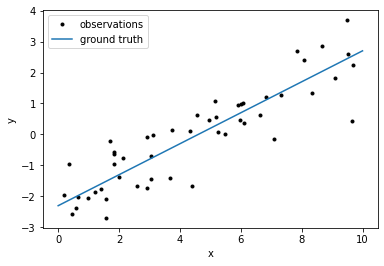

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

true_params = np.array([0.5, -2.3, -0.23])

N = 50
t = np.linspace(0, 10, 2)
x = np.random.uniform(0, 10, 50)
y = x * true_params[0] + true_params[1]
y_obs = y + np.exp(true_params[-1]) * np.random.randn(N)

plt.plot(x, y_obs, ".k", label="observations")
plt.plot(t, true_params[0]*t + true_params[1], label="ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## PyTorch

In [3]:
import torch

class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.m = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        self.b = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        self.logs = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        
    def forward(self, x, y):
        mean = self.m * x + self.b
        loglike = -0.5 * torch.sum((y - mean) ** 2 * torch.exp(-2 * self.logs) + 2 * self.logs)
        return loglike

torch_model = torch.jit.script(LinearModel())
torch_params = [torch_model.m, torch_model.b, torch_model.logs]
args = [torch.tensor(x, dtype=torch.double), torch.tensor(y_obs, dtype=torch.double)]

def torch_logp_dlogp_func(x):
    for i, p in enumerate(torch_params):
        p.data = torch.tensor(x[i])
        if p.grad is not None:
            p.grad.detach_()
            p.grad.zero_()

    result = torch_model(*args)
    result.backward()

    return result.detach().numpy(), np.array([p.grad.numpy() for p in torch_params])

In [4]:
%timeit torch_logp_dlogp_func(np.zeros(3))

269 µs ± 24.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Please see [`sample_pytorch_logp_dlogp_func.py`](https://github.com/eigenfoo/littlemcmc/tree/main/docs/_static/scripts/sample_pytorch_logp_dlogp_func.py) for a working example. Theoretically, however, all that's needed is to run the following snippet:

```python
trace, stats = lmc.sample(
    logp_dlogp_func=torch_logp_dlogp_func, model_ndim=3, tune=500, draws=1000, chains=4,
)
```

## JAX

In [5]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

def jax_model(params):
    mean = params[0] * x + params[1]
    loglike = -0.5 * jnp.sum((y_obs - mean) ** 2 * jnp.exp(-2 * params[2]) + 2 * params[2])
    return loglike

@jax.jit
def jax_model_and_grad(x):
    return jax_model(x), jax.grad(jax_model)(x)


def jax_logp_dlogp_func(x):
    v, g = jax_model_and_grad(x)
    return np.asarray(v), np.asarray(g)

In [6]:
%timeit jax_logp_dlogp_func(np.zeros(3))

/Users/george/littlemcmc/venv/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


261 µs ± 88.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Please see [`sample_jax_logp_dlogp_func.py`](https://github.com/eigenfoo/littlemcmc/tree/main/docs/_static/scripts/sample_jax_logp_dlogp_func.py) for a working example. Theoretically, however, all that's needed is to run the following snippet:

```python
trace, stats = lmc.sample(
    logp_dlogp_func=jax_logp_dlogp_func, model_ndim=3, tune=500, draws=1000, chains=4,
)
```

## PyMC3

In [7]:
import pymc3 as pm
import theano

with pm.Model() as pm_model:
    pm_params = pm.Flat("pm_params", shape=3)
    mean = pm_params[0] * x + pm_params[1]
    pm.Normal("obs", mu=mean, sigma=pm.math.exp(pm_params[2]), observed=y_obs)
    
pm_model_and_grad = pm_model.fastfn([pm_model.logpt] + theano.grad(pm_model.logpt, pm_model.vars))

def pm_logp_dlogp_func(x):
    return pm_model_and_grad(pm_model.bijection.rmap(x))

In [8]:
%timeit pm_logp_dlogp_func(np.zeros(3))

42.2 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
trace, stats = lmc.sample(
    logp_dlogp_func=pm_logp_dlogp_func,
    model_ndim=3,
    tune=500,
    draws=1000,
    chains=4,
)

## Visualize Traces with ArviZ

Just to sanity check our results, let's visualize all the traces using ArviZ. At the time of writing there's no way to easily load the `np.ndarrays` arrays that `littlemcmc` returns into an `az.InferenceDataset`. Hopefully one day we'll have an `az.from_littlemcmc` method... but until then, please use this code snippet!

In [10]:
def arviz_from_littlemcmc(trace, stats):
    return az.InferenceData(
        posterior=az.dict_to_dataset({"x": trace}),
        sample_stats=az.dict_to_dataset({k: v.squeeze() for k, v in stats.items()})
    )

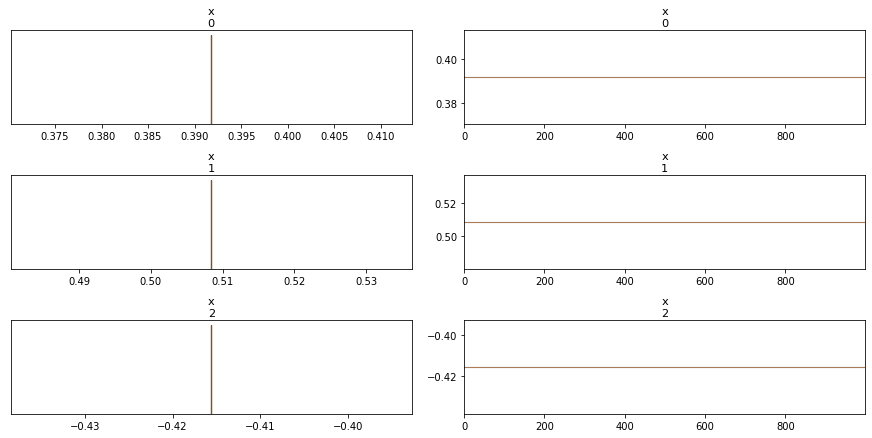

In [12]:
import arviz as az

dataset = arviz_from_littlemcmc(trace, stats)

az.plot_trace(dataset)
plt.show()